In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
## Read coordinates and indices

grid_coordinates = []
with open('../../../../Grids/Pe_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../../../Grids/Pe_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../../../Grids/Pe_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

bott_indices = []
with open('../../Pe_Bott_indices_B_scale_0100.txt', 'r') as reader:
    line = reader.readline()
    
    while line != '':
        ele = line.replace('(', '').replace(')', '')
        elements = ele.split(',')
        package = (float(elements[0]), int(elements[1]))
        line = reader.readline()
        bott_indices.append(package)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

## IMPORTANT WE WILL USE THE GRID SCALED FOR ROTATIONS THIS MAKES THE WORK EASIER ##

# Read the phases in
evec_phases = []
with open('../../../../Separate_files/Pe_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()

phases_ind = [(ele, count) for count, ele in enumerate(evec_phases)]

# Time evolution by giving index of states
def time_evolve_evec(group_of_states, coefficients, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [c*np.exp(-1j*(eval[i]/hbar)*t)*evec[i] for i, c in zip(group_of_states, coefficients)]

    psi = sum([x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states


In [3]:
# Now load in the pure eigenvalues and eigenvectors from either calculation
pure_evals = np.loadtxt("Eigenvalues/pure.txt")
pure_evecs = np.loadtxt("Eigenvectors/pure.txt", dtype= np.complex128)

unpure_positive_evals = np.loadtxt("Eigenvalues/unpure_positive.txt", skiprows= 1)
unpure_positive_evecs = np.loadtxt("Eigenvectors/unpure_positive.txt", dtype= np.complex128)

# Now define the group of indices of interest. They stem from analysis script
edge_group = [25, 26, 27, 28]
# These have increasing energies and phases following from eachother
group = [25, 26]
V_scale = np.loadtxt("Eigenvalues/unpure_positive.txt", max_rows= 1)
delta_E = pure_evals[26] - pure_evals[25]
print(delta_E)

0.06539387168857935


In [4]:
"""## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

# Set figure up first
fig, ax = plt.subplots(figsize=(6,6))
# Set bascis
sites = ax.scatter(x=[], y=[], c=[])

xs = [w[0] for w in grid_scaled]
ys = [w[1] for w in grid_scaled]


# Set timesteps, state of choice for animation, and number of frames
timestep = 1
n_frames = 600
B_scale = 0.25

psi_0, dos_0 = time_evolve_evec(group, 0, pure_evecs, pure_evals)

dos_max = (1/5)*max(dos_0)

plt.set_cmap('hot_r')

# This function will do the animating
def update(i):
    plt.clf()
    # t is the steps we progress, timestep sets the steplength
    t = i * timestep

    # Using the time evolution to find density of states for each increment
    psi, dos = time_evolve_evec(group, t, pure_evecs, pure_evals)
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
    plt.plot([],[], linestyle= '', label= f'V = 0')
    plt.title(f'Timestep= {timestep} and Frames= {n_frames}')
    plt.legend(loc= 3)
    plt.colorbar(cf)
    plt.axis('equal')


anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

anim.save(f'Pure/edge.gif', writer='imagemagick', fps=30)

#anim"""

"## Magic line for animation\n%matplotlib inline\n# Attempt at animating time evolution\n\n# Set figure up first\nfig, ax = plt.subplots(figsize=(6,6))\n# Set bascis\nsites = ax.scatter(x=[], y=[], c=[])\n\nxs = [w[0] for w in grid_scaled]\nys = [w[1] for w in grid_scaled]\n\n\n# Set timesteps, state of choice for animation, and number of frames\ntimestep = 1\nn_frames = 600\nB_scale = 0.25\n\npsi_0, dos_0 = time_evolve_evec(group, 0, pure_evecs, pure_evals)\n\ndos_max = (1/5)*max(dos_0)\n\nplt.set_cmap('hot_r')\n\n# This function will do the animating\ndef update(i):\n    plt.clf()\n    # t is the steps we progress, timestep sets the steplength\n    t = i * timestep\n\n    # Using the time evolution to find density of states for each increment\n    psi, dos = time_evolve_evec(group, t, pure_evecs, pure_evals)\n    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)\n    plt.plot([],[], linestyle= '', label= f'V = 0')\n    plt.title(f'Timestep= {timestep} and Frames= {n_frame

In [5]:
for t in np.arange(0,90,30):
    # Set figure up first
    fig, ax = plt.subplots(figsize=(6,6))

    # Plot all possible paths between vertices
    for i,j in zip(grid_scaled, jump_scaled):
        xs = [w[0] for w in j]
        ys = [w[1] for w in j]
        for l,k in zip(xs,ys):
            ax.plot([i[0], l], [i[1], k], color= 'k', zorder= 1, linewidth= 0.5)

    # Get points for scatter plot
    xs = [w[0] for w in grid_scaled]
    ys = [w[1] for w in grid_scaled]

    # Time evolution segment
    B_scale = 0.25
    # Initial setup
    coefs = [1,1]
    psi_0, dos_0 = time_evolve_evec(group, coefs, 0, pure_evecs, pure_evals)
    dos_max = max(dos_0)

    # Actual evolution
    time = t
    psi, dos = time_evolve_evec(group, coefs, time, pure_evecs, pure_evals)

    # Plotting part
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
    plt.colorbar(cf)
    plt.axis('equal')

    plt.set_cmap('hot_r')
    plt.savefig(f'TE_frames/pure/Pe_edge_time_{t}', bbox_inches= 'tight')
    plt.close()

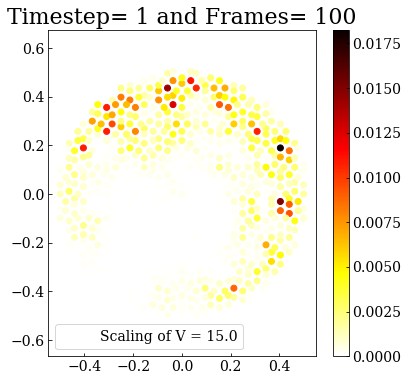

In [6]:
## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

# Set figure up first
fig, ax = plt.subplots(figsize=(6,6))
# Set bascis
sites = ax.scatter(x=[], y=[], c=[])

xs = [w[0] for w in grid_scaled]
ys = [w[1] for w in grid_scaled]


# Set timesteps, state of choice for animation, and number of frames
timestep = 1
n_frames = 100

coefs = [1,1]

psi_0, dos_0 = time_evolve_evec(group, coefs, 0, pure_evecs, pure_evals)

dos_max = max(dos_0)

plt.set_cmap('hot_r')

# This function will do the animating
def update(i):
    plt.clf()
    # t is the steps we progress, timestep sets the steplength
    t = i * timestep

    # Using the time evolution to find density of states for each increment
    psi, dos = time_evolve_evec(group, coefs, t, unpure_positive_evecs, unpure_positive_evals)
    cf = plt.scatter(x= xs, y= ys, c= dos, vmin=0, vmax= dos_max)
    plt.plot([],[], linestyle= '', label= f'Scaling of V = {V_scale}')
    plt.title(f'Timestep= {timestep} and Frames= {n_frames}')
    plt.legend(loc= 3)
    plt.colorbar(cf)
    plt.axis('equal')


anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

anim.save(f'Unpure_positive/V_{V_scale}_edge.gif', writer='imagemagick', fps=30)

#anim